# 2-D deformational flow with pre-trained model

Jiawei Zhuang; 02/15/2020

Ref:
- Kent et al. 2013 https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.2208

# Import

In [1]:
!pip install git+https://github.com/JiaweiZhuang/data-driven-pdes@fix-beam
%tensorflow_version 1.x

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()

  Cloning https://github.com/JiaweiZhuang/data-driven-pdes (to revision fix-beam) to /tmp/pip-req-build-bt0af11n
  Running command git clone -q https://github.com/JiaweiZhuang/data-driven-pdes /tmp/pip-req-build-bt0af11n
  Running command git checkout -b fix-beam --track origin/fix-beam
  Switched to a new branch 'fix-beam'
  Branch 'fix-beam' set up to track remote branch 'fix-beam' from 'origin'.
  Created wheel for pde-superresolution-2d: filename=pde_superresolution_2d-0.0.0-cp36-none-any.whl size=78424 sha256=373f4e624f2722ccea895ff8a4f40c8af81a782e4bd81f08d0cae1d3112bada8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ozomiv2j/wheels/11/40/1b/8aa5500c857cb40090657a133e4b270f8c989c194c0f6d80ac
Successfully built pde-superresolution-2d


In [2]:
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import readers
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils

from google.colab import files

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Setup deformational flow test case

## Velocity field

In [0]:
period = 5

def deformational_flow(x, y, t, period=period):
    u = np.sin(np.pi*x)**2 * np.sin(2*np.pi*y) * np.cos(np.pi*t/period)
    v = -np.sin(np.pi*y)**2 * np.sin(2*np.pi*x) * np.cos(np.pi*t/period)
    return u, v

In [0]:
# Feel free to change the grid resolution; the pretrained model works with different resolutions
resolution = 64
# resolution = 32

nx = ny = resolution
dx = dy = 1/resolution
x, y = np.meshgrid(dx * np.arange(nx), dy * np.arange(ny))

In [5]:
u, v = deformational_flow(x, y, t=0)
u.shape

(64, 64)

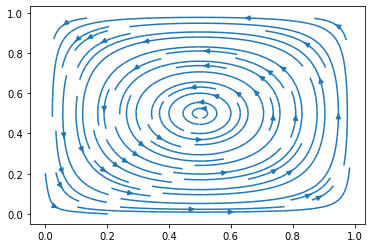

In [6]:
plt.streamplot(x, y, u, v)

Text(0.5, 1.0, 'velocity magnitude')

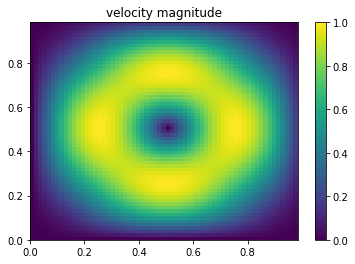

In [7]:
plt.pcolormesh(x, y, np.sqrt(u**2 + v**2))
plt.colorbar()
plt.title('velocity magnitude')

## Stagger velocity field

In [0]:
simulation_grid = grids.Grid.from_period(nx, 1)
x, y = simulation_grid.get_mesh()

# this is transposed compared to the previous meshgrid
x_1d = x[:,0]  
y_1d = y[0,:]

In [0]:
def staggered_flow(grid, t):
  # both ML model and baseline uses staggered grid (finite volume)

  x, y = grid.get_mesh(shift=(1, 0))
  u, _ = deformational_flow(x, y, t)

  x, y = grid.get_mesh(shift=(0, 1))
  _, v = deformational_flow(x, y, t)

  return u, v

In [10]:
u, v = staggered_flow(simulation_grid, t=period)
u.shape

(64, 64)

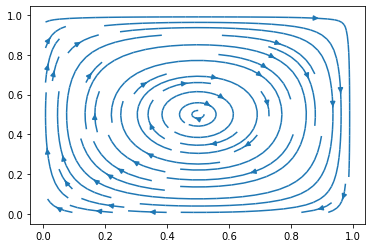

In [11]:
plt.streamplot(x_1d, y_1d, u.T, v.T, density=0.8)

Text(0.5, 1.0, 'velocity magnitude')

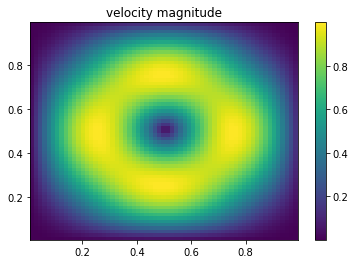

In [12]:
plt.pcolormesh(x_1d, y_1d, np.sqrt(u**2 + v**2))
plt.colorbar()
plt.title('velocity magnitude')

## Initial concentration

In [13]:
def initial_concentration(x, y, beta=4):
  # bigger beta -> smaller blob
  r = np.clip(beta*np.sqrt((x - 0.25)**2 + (y-0.25)**2), a_min=None, a_max=1)

  c1 = 0.5 * (1 + np.cos(np.pi*r))

  # Additional tracers to evaluate inter-tracer correlation
  # See Equation 32-35 in Kent et al. 2013
  c2 = 0.9 - 0.8 * c1**2

  c3 = 0.1 * np.zeros_like(c1)
  c3[r<0.5] = 1.0

  c4 = 1 - 0.3 * (c1 + c2 + c3)

  return np.stack([c1, c2, c3, c4])

c_init = initial_concentration(x, y, beta=4)
c_init.shape  # (channel, x, y)

(4, 64, 64)

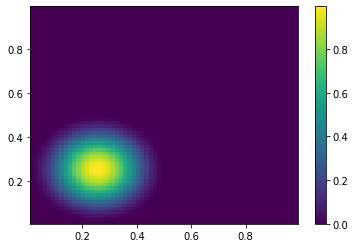

In [14]:
plt.pcolormesh(x, y, c_init[0])
plt.colorbar()

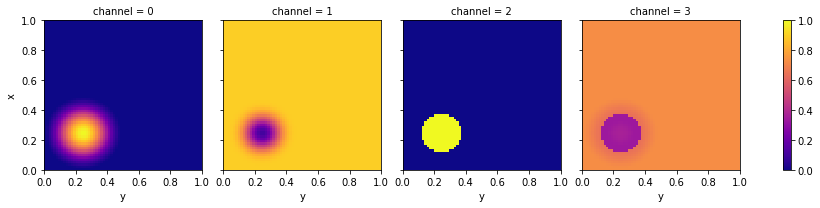

In [15]:
xarray.DataArray(
    c_init,
    dims=['channel', 'x', 'y'],
    coords={'x': x_1d,
            'y': y_1d}
).plot(col='channel', cmap='plasma')

# Baseline model

## Figuring out proper grid size and time step

In [0]:
# simulation_grid = grids.Grid.from_period(nx, 1)  # defined earlier

In [17]:
simulation_grid.step

0.015625

In [18]:
dx

0.015625

In [0]:
equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.5)
fd_model = models.FiniteDifferenceModel(equation, simulation_grid)

In [20]:
dt = fd_model.equation.get_time_step(fd_model.grid)
dt

0.0078125

In [21]:
dx/dt

2.0

In [22]:
num_periods = 4  # repeat the flow many times

num_steps = int(period*num_periods//dt) 
assert num_steps * dt == period*num_periods
num_steps

2560

## Integrate and plot

In [23]:
state = {
    'concentration': c_init.astype(np.float32)
}

save_step = 8

def integrate(model, state, num_steps: int, save_step = save_step, stagger=True):
  num_channels = state['concentration'].shape[0]
  results = [state['concentration']]
  for step in range(num_steps):
    t = step * dt
    if stagger:
      u, v = staggered_flow(simulation_grid, t=t)
    else:
      u, v = deformational_flow(x, y, t=t)
    # no need to transpose u and v if using staggered flow computed via grid.get_mesh()
    state['x_velocity'] = np.broadcast_to(u, (num_channels, resolution, resolution)).astype(np.float32)
    state['y_velocity'] = np.broadcast_to(v, (num_channels, resolution, resolution)).astype(np.float32)

    state = model.take_time_step(state)
    if step % save_step == 0:
      print(step, end=' ')
      results.append(state['concentration'].numpy())

  results = np.stack(results)

  dr_results = xarray.DataArray(
      results, 
      dims=['t', 'channel', 'x', 'y'],
      coords={'t': np.arange(0, num_steps+1, save_step)*dt,
              'x': x_1d,
              'y': y_1d}
              )

  return dr_results

%time dr_vanleer = integrate(fd_model, state, num_steps, stagger=True)

dr_vanleer.sizes

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0 8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 472 480 488 496 504 512 520 528 536 544 552 560 568 576 584 592 600 608 616 624 632 640 648 656 664 672 680 688 696 704 712 720 728 736 744 752 760 768 776 784 792 800 808 816 824 832 840 848 856 864 872 880 888 896 904 912 920 928 936 944 952 960 968 976 984 992 1000 1008 1016 1024 1032 1040 1048 1056 1064 1072 1080 1088 1096 1104 1112 1120 1128 1136 1144 1152 1160 1168 1176 1184 1192 1200 1208 1216 1224 1232 1240 1248 1256 1264 1272 1280 1288 1296 1304 1312 1320 1328 1336 1344 1352 1360 1368 1376 1384 1392 1400 1408 1416 1424 1432 1440 1448 1456 1464 1472 1480 1488 1496 1504 1512 1520 1528 1536 1544 1552 1560 1568 1576 1584 1592 1600 1608 1616 1624 1632 1640 1648 1656 1664 1

Frozen({'t': 321, 'channel': 4, 'x': 64, 'y': 64})

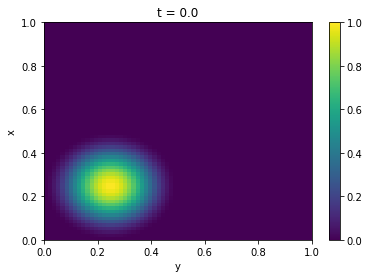

In [24]:
dr_vanleer.isel(t=0, channel=0).plot(vmin=0.0, vmax=1.0)

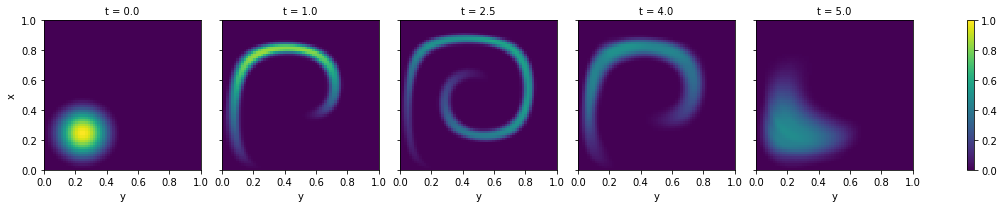

In [25]:
(dr_vanleer
.isel(channel=0)
.sel(t=[0, 1, 2.5, 4, 5.0])
.plot(col='t', vmin=0.0, vmax=1.0)
)

# Pre-trained neural network model

## Load trained model

Manually upload `model_config.json` and `weights_final.h5` here.

In [26]:
ls

2d-deformation.png     figure_deformation/  sample_data/
2d-deform-entropy.png  model_config.json    weights_final.h5


In [27]:
model_config = readers.load_metadata('model_config.json')
model_config

{'activation': 'relu',
 'constrained_accuracy_order': 1,
 'filters': 256,
 'fixed_keys': ['concentration'],
 'kernel_size': 3,
 'num_layers': 10,
 'num_time_steps': 10,
 'stencil_size': 5}

In [28]:
nn_model = model_utils.model_from_config(simulation_grid, model_config)
nn_model

In [0]:
state = {
    'concentration': c_init.astype(np.float32)
}

u, v = deformational_flow(x, y, 0, period=period)
state['x_velocity'] = np.broadcast_to(u.T, (4, resolution, resolution)).astype(np.float32)
state['y_velocity'] = np.broadcast_to(v.T, (4, resolution, resolution)).astype(np.float32)

_ = nn_model.take_time_step(state)  # just to initialize weights

In [30]:
%time model_utils.load_weights(nn_model, 'weights_final.h5')

CPU times: user 419 ms, sys: 118 ms, total: 536 ms
Wall time: 524 ms


## Integrate neural network model

In [31]:
state = {
    'concentration': c_init.astype(np.float32)
}

%time dr_ml = integrate(nn_model, state, num_steps, stagger=True)

dr_ml.sizes

0 8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 472 480 488 496 504 512 520 528 536 544 552 560 568 576 584 592 600 608 616 624 632 640 648 656 664 672 680 688 696 704 712 720 728 736 744 752 760 768 776 784 792 800 808 816 824 832 840 848 856 864 872 880 888 896 904 912 920 928 936 944 952 960 968 976 984 992 1000 1008 1016 1024 1032 1040 1048 1056 1064 1072 1080 1088 1096 1104 1112 1120 1128 1136 1144 1152 1160 1168 1176 1184 1192 1200 1208 1216 1224 1232 1240 1248 1256 1264 1272 1280 1288 1296 1304 1312 1320 1328 1336 1344 1352 1360 1368 1376 1384 1392 1400 1408 1416 1424 1432 1440 1448 1456 1464 1472 1480 1488 1496 1504 1512 1520 1528 1536 1544 1552 1560 1568 1576 1584 1592 1600 1608 1616 1624 1632 1640 1648 1656 1664 1672 1680 1688 1696 1704 1712 1720 1728 1736 1744 1752 1760 1768 1776 1784 1792 1800 1808 1816 

Frozen({'t': 321, 'channel': 4, 'x': 64, 'y': 64})

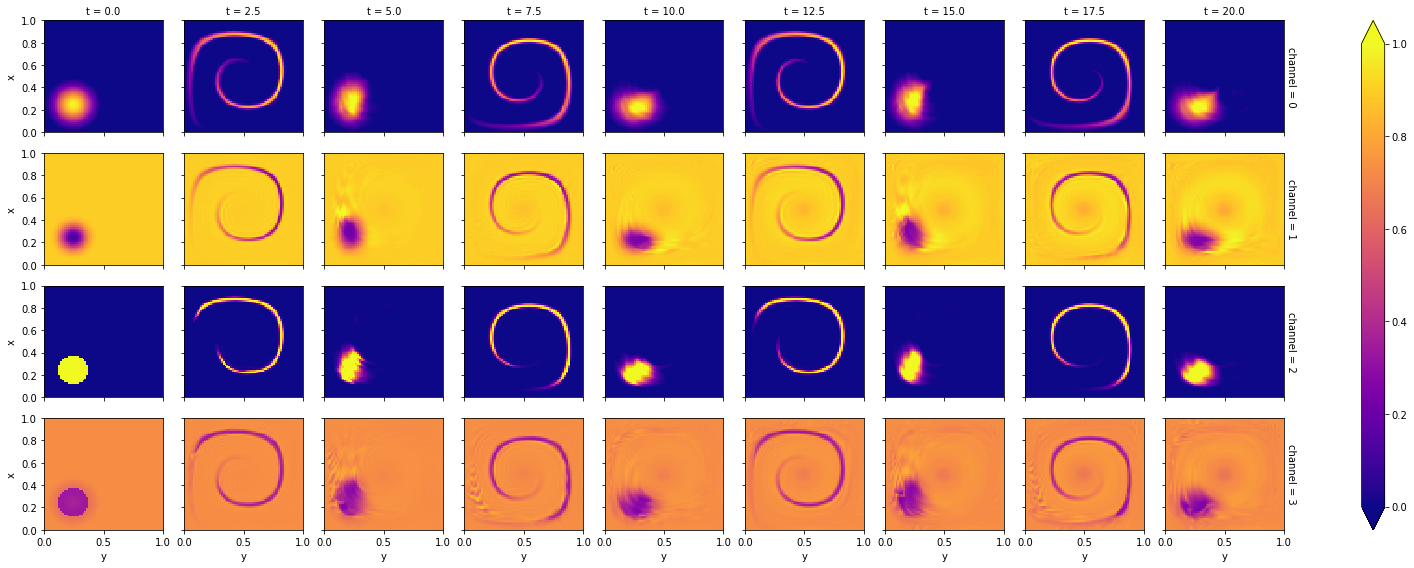

In [32]:
plot_times = np.arange(0, period*num_periods+1e-3, period/2)

(dr_ml
.sel(t=plot_times)
.plot(col='t', row='channel', vmin=0.0, vmax=1.0, aspect=1.2, size=2, cmap='plasma')
)

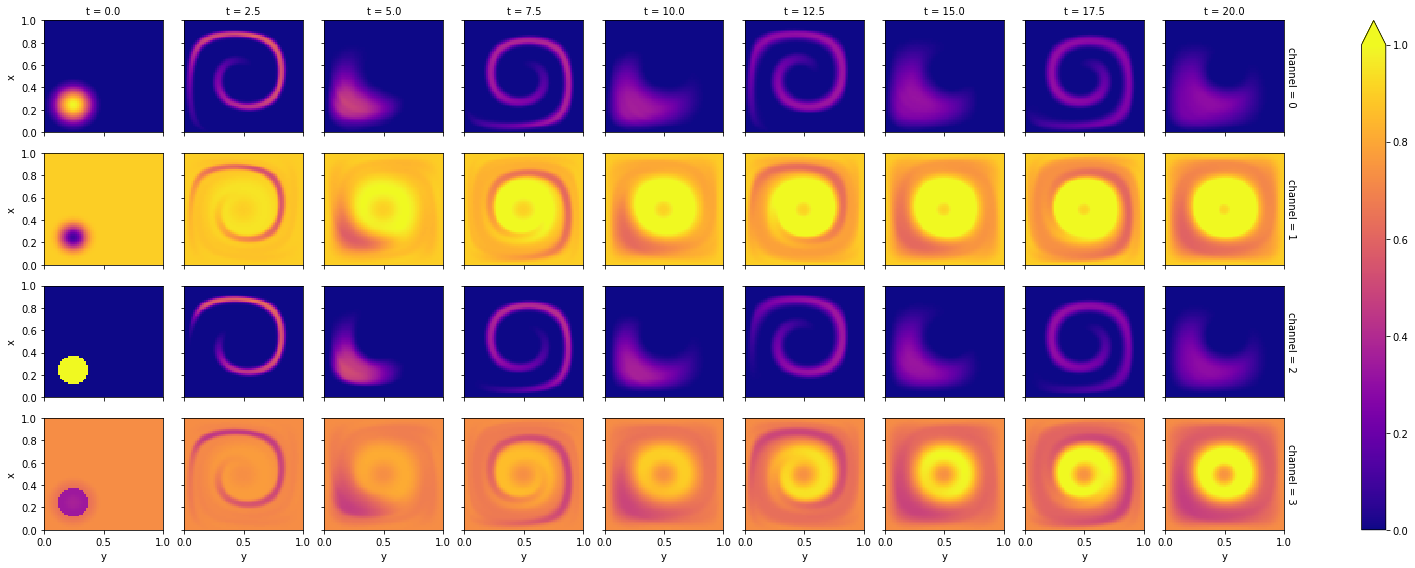

In [33]:
# to compare
(dr_vanleer
.sel(t=plot_times)
.plot(col='t', row='channel', vmin=0.0, vmax=1.0, aspect=1.2, size=2, cmap='plasma')
)

# Error metrics

## Error norm

In [0]:
def diff_final_init(dr):
  return dr.isel(t=-1) - dr.isel(t=0)

def l1_error(dr):
  dr_diff = diff_final_init(dr)
  error = dr_diff.pipe(abs).mean(dim=['x', 'y'])
  return error

def l2_error(dr):
  dr_diff = diff_final_init(dr)
  error = (dr_diff**2).mean(dim=['x', 'y']).pipe(np.sqrt)
  return error

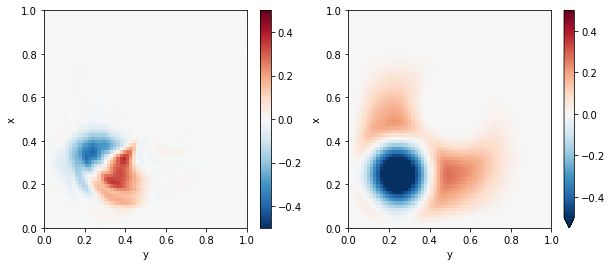

In [35]:
plt.figure(figsize=[10, 4])

plt.subplot(1, 2, 1)
diff_final_init(dr_ml.isel(channel=0)).plot(vmax=0.5)

plt.subplot(1, 2, 2)
diff_final_init(dr_vanleer.isel(channel=0)).plot(vmax=0.5)

In [36]:
l1_error(dr_ml)

<xarray.DataArray (channel: 4)>
array([0.0216065 , 0.02814753, 0.02970366, 0.02355806], dtype=float32)
Dimensions without coordinates: channel

In [37]:
l1_error(dr_vanleer)

<xarray.DataArray (channel: 4)>
array([0.05787882, 0.1599398 , 0.07635427, 0.13039342], dtype=float32)
Dimensions without coordinates: channel

In [38]:
l2_error(dr_ml)

<xarray.DataArray (channel: 4)>
array([0.06525381, 0.05225297, 0.11911231, 0.04121427], dtype=float32)
Dimensions without coordinates: channel

In [39]:
l2_error(dr_vanleer)

<xarray.DataArray (channel: 4)>
array([0.12929592, 0.20248835, 0.18746264, 0.16323298], dtype=float32)
Dimensions without coordinates: channel

In [40]:
dr_metric = xarray.concat([l1_error(dr_ml), l1_error(dr_vanleer),  
                           l2_error(dr_ml), l2_error(dr_vanleer)], dim='error metric')

dr_metric.coords['error metric'] = ['l1 nn', 'l1 vanleer', 'l2 nn', 'l2 vanleer']

df_metric = dr_metric.to_pandas()
df_metric.loc['l1 vanleer/nn ratio'] = df_metric.loc['l1 vanleer'] / df_metric.loc['l1 nn']
df_metric.loc['l2 vanleer/nn ratio'] = df_metric.loc['l2 vanleer'] / df_metric.loc['l2 nn']

pd.options.display.precision = 3
df_metric

channel,0,1,2,3
error metric,,,,
l1 nn,0.022,0.028,0.030,0.024
l1 vanleer,0.058,0.160,0.076,0.130
l2 nn,0.065,0.052,0.119,0.041
l2 vanleer,0.129,0.202,0.187,0.163
l1 vanleer/nn ratio,2.679,5.682,2.571,5.535
l2 vanleer/nn ratio,1.981,3.875,1.574,3.961


## Maximum

In [0]:
plt.rcParams['font.size'] = 15

In [42]:
reversed_points = np.arange(num_periods) * period + period/2
reversed_points

array([ 2.5,  7.5, 12.5, 17.5])

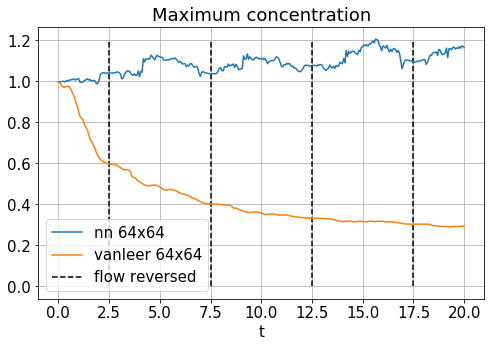

In [43]:
channel = 0

plt.figure(figsize=[8, 5])

dr_ml.isel(channel=channel).max(dim=['x', 'y']).plot(label='nn {0}x{0}'.format(resolution))
dr_vanleer.isel(channel=channel).max(dim=['x', 'y']).plot(label='vanleer {0}x{0}'.format(resolution))
plt.vlines(x=reversed_points, ymin=0.0, ymax=1.2, linestyles='dashed', label='flow reversed')

plt.legend()
plt.title('Maximum concentration')
plt.grid()


## Entropy

In [0]:
def compute_entropy(dr):
  # will encouter numerical issues without a small non-zero background
  entropy = -(dr * np.log(dr+1e-3)).mean(dim=['x', 'y'])
  return entropy / entropy.isel(t=0)

/usr/local/lib/python3.6/dist-packages/xarray/core/computation.py:601: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


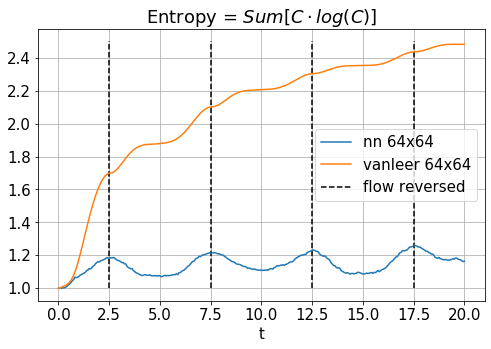

In [45]:
channel = 0

plt.figure(figsize=[8, 5])
compute_entropy(dr_ml.isel(channel=channel)).plot(label='nn {0}x{0}'.format(resolution))
compute_entropy(dr_vanleer.isel(channel=channel)).plot(label='vanleer {0}x{0}'.format(resolution))
plt.vlines(x=reversed_points, ymin=1.0, ymax=2.5, linestyles='dashed', label='flow reversed')

plt.legend()
plt.title(r'Entropy = $Sum[C \cdot log(C)]$');
plt.grid()

## Total variation diminishing?

TVD only holds for 1D, not 2D!

In [0]:
def compute_tv(dr):
  """Total variantion"""
  # https://www.ams.org/journals/mcom/1985-45-171/S0025-5718-1985-0790641-4/S0025-5718-1985-0790641-4.pdf

  dr_pad_x = xarray.concat([dr, dr.isel(x=0)], dim='x')
  tv_x = dr_pad_x.diff('x').pipe(abs)

  dr_pad_y = xarray.concat([dr, dr.isel(y=0)], dim='y')
  tv_y = dr_pad_y.diff('y').pipe(abs)#
  
  # tv = np.sqrt(tv_x**2 + tv_y**2)
  tv = tv_x + tv_y
  return tv.sum(dim=['x', 'y'])

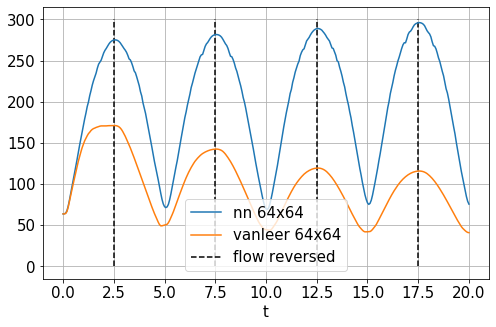

In [47]:
channel = 0

plt.figure(figsize=[8, 5])
compute_tv(dr_ml.isel(channel=channel)).plot(label='nn {0}x{0}'.format(resolution))
compute_tv(dr_vanleer.isel(channel=channel)).plot(label='vanleer {0}x{0}'.format(resolution))
plt.vlines(x=reversed_points, ymin=0.0, ymax=300, linestyles='dashed', label='flow reversed')

plt.legend()
plt.grid()

## Non-linear correlation

In [0]:
def inter_tracer_scatter(dr, ch1=0, ch2=1, t=2.5):
  dr1 = dr.isel(channel=ch1)
  dr2 = dr.isel(channel=ch2)
  plt.scatter(dr1.isel(t=0), dr2.isel(t=0), s=3, c='k')
  plt.scatter(dr1.sel(t=t), dr2.sel(t=t), s=3, alpha=0.3)

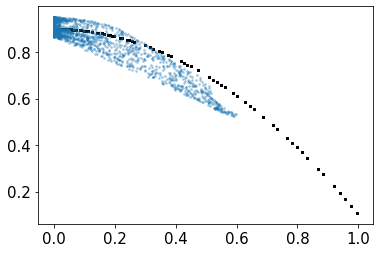

In [49]:
inter_tracer_scatter(dr_vanleer)

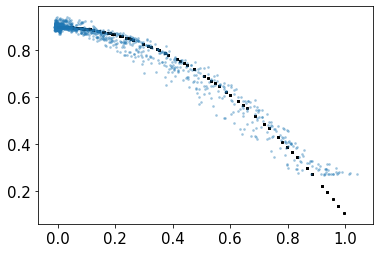

In [50]:
inter_tracer_scatter(dr_ml)

# Movies

In [0]:
plt.rcParams['font.size'] = 15

In [0]:
!rm -rf figure_deformation
!mkdir -p figure_deformation

In [53]:
%%time

import os

# for ch in range(4):
for ch in range(1):
  print('\n channel:', ch)
  os.makedirs(f'./figure_deformation/channel_{ch}/', exist_ok=True)
  # for t in range(dr_ml['t'].size):
  for t in range(1):
    print(t, end=' ')
    fig, axes = plt.subplots(1, 2, figsize=[12, 4])

    dr_ml.isel(t=t, channel=ch).plot(ax=axes[0], extend='neither',
                                          vmin=0, vmax=1, cmap='plasma')
    axes[0].set_title('nn 64x64')

    dr_vanleer.isel(t=t, channel=ch).plot(ax=axes[1], extend='neither',
                                              vmin=0, vmax=1, cmap='plasma')
    axes[1].set_title('vanleer 64x64')

    fig.suptitle('t={:.4f}'.format(float(dr_ml['t'][t])), y=1.02)
    fig.savefig(f'./figure_deformation/channel_{ch}/{t:03d}.png', dpi=144,  bbox_inches='tight')
    plt.close(fig)


 channel: 0
0 CPU times: user 556 ms, sys: 9.11 ms, total: 565 ms
Wall time: 566 ms


In [54]:
!ls -lh figure_deformation/channel_0/

total 40K
-rw-r--r-- 1 root root 40K Feb 15 22:03 000.png


In [0]:
# files.download('figure_deformation/channel_0/000.png')

# Polished plot for paper

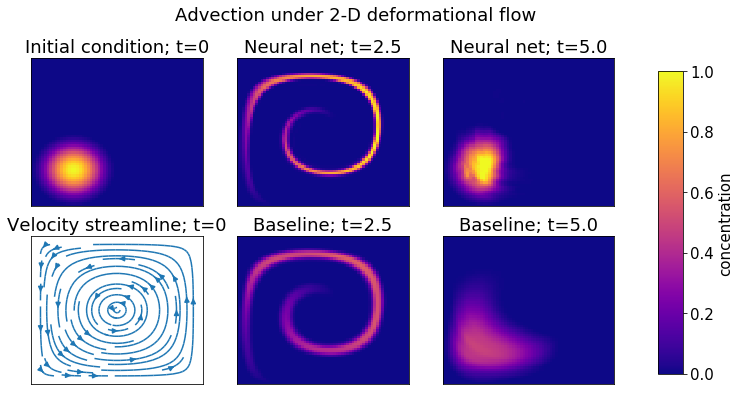

In [56]:
t0 = 0
t1 = 2.5
t2 = 5.0
ch = 0

fig, axes = plt.subplots(2, 3, figsize=[12, 6])

axes[1][0].streamplot(x_1d, y_1d, u.T, v.T, density=0.8)
axes[1][0].set_title('Velocity streamline; t=0')

plot_kwargs = dict(vmin=0, vmax=1, cmap='plasma')
axes[0][0].pcolormesh(dr_ml.sel(t=t0, channel=ch), **plot_kwargs)
axes[0][0].set_title('Initial condition; t=0')

axes[0][1].pcolormesh(dr_ml.sel(t=t1, channel=ch), **plot_kwargs)
axes[0][1].set_title(f'Neural net; t={t1}')

axes[1][1].pcolormesh(dr_vanleer.sel(t=t1, channel=ch), **plot_kwargs)
axes[1][1].set_title(f'Baseline; t={t1}')

axes[0][2].pcolormesh(dr_ml.sel(t=t2, channel=ch), **plot_kwargs)
axes[0][2].set_title(f'Neural net; t={t2}')

im = axes[1][2].pcolormesh(dr_vanleer.sel(t=t2, channel=ch), **plot_kwargs)
axes[1][2].set_title(f'Baseline; t={t2}')

# add shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('concentration')

# hide all ticks
for ax in axes.flatten():
  ax.set_xticks([])
  ax.set_yticks([])

fig.suptitle('Advection under 2-D deformational flow'.format(float(dr_ml['t'][t])), y=1.0)
fig.savefig('2d-deformation.png', dpi=288, bbox_inches='tight')
# fig.tight_layout()

In [57]:
ls -lh

total 20M
-rw-r--r-- 1 root root 306K Feb 15 22:03 2d-deformation.png
-rw-r--r-- 1 root root 135K Feb 15 21:59 2d-deform-entropy.png
drwxr-xr-x 3 root root 4.0K Feb 15 22:03 figure_deformation/
-rw-r--r-- 1 root root  229 Feb 15 21:54 model_config.json
drwxr-xr-x 1 root root 4.0K Feb  5 18:37 sample_data/
-rw-r--r-- 1 root root  19M Feb 15 21:56 weights_final.h5


In [0]:
# files.download('2d-deformation.png')

/usr/local/lib/python3.6/dist-packages/xarray/core/computation.py:601: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


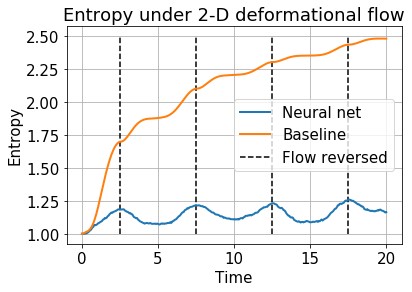

In [59]:
channel = 0

plt.figure(figsize=[6, 4])
compute_entropy(dr_ml.isel(channel=channel)).plot(
    label='Neural net', linewidth=2.0)
compute_entropy(dr_vanleer.isel(channel=channel)).plot(
    label='Baseline', linewidth=2.0)
plt.vlines(x=reversed_points, ymin=1.0, ymax=2.5, linestyles='dashed', label='Flow reversed')

plt.xlabel('Time')
plt.ylabel('Entropy')

plt.legend()
# plt.title(r'Entropy = -k$\sum C_i \cdot log(C_i)$');
plt.title(r'Entropy under 2-D deformational flow');
plt.grid()

plt.savefig('2d-deform-entropy.png', dpi=288, bbox_inches='tight')

In [0]:
# files.download('2d-deform-entropy.png')